In [1]:
__author__='Wentao'
#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it and figure out what it is due to.

In [3]:
data = np.load('MTA_Fare.npy')

In [5]:
print data.dtype

int32


In [6]:
print data.shape

(600L, 23L, 194L)


In [7]:
data = np.where(data != -1, data, np.nan)

In [8]:
# now I gonna add up all the stations and ride types
ridetype_sum = np.nansum(data, axis=0)/23
station_sum = np.nansum(data, axis=1)/600

In [10]:
station1 = pd.DataFrame(station_sum.T)
station1.index = pd.date_range('5/21/2010', periods=194, freq='W-FRI')

<function matplotlib.pyplot.show>

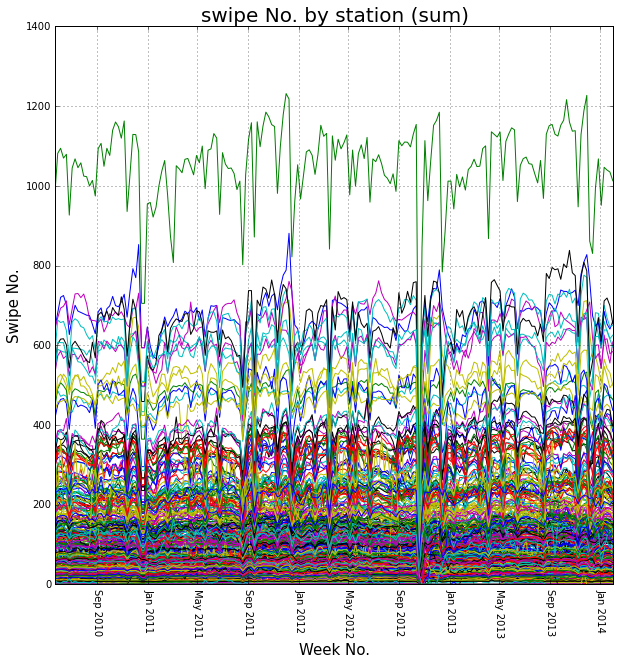

In [11]:
fig1 = plt.figure(figsize=(10,10))
fig1.add_subplot(111)
plt.plot(station1.index, station1)
plt.title('swipe No. by station (sum)',fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week No.', fontsize=15)
plt.ylabel('Swipe No.', fontsize=15)
plt.grid()
plt.show

In [14]:
"""ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])"""
ridetype1 = pd.DataFrame(ridetype_sum.T)
ridetype1.columns = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
                    'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t','umlim',
                    'xbus','stud']
ridetype1.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

<function matplotlib.pyplot.show>

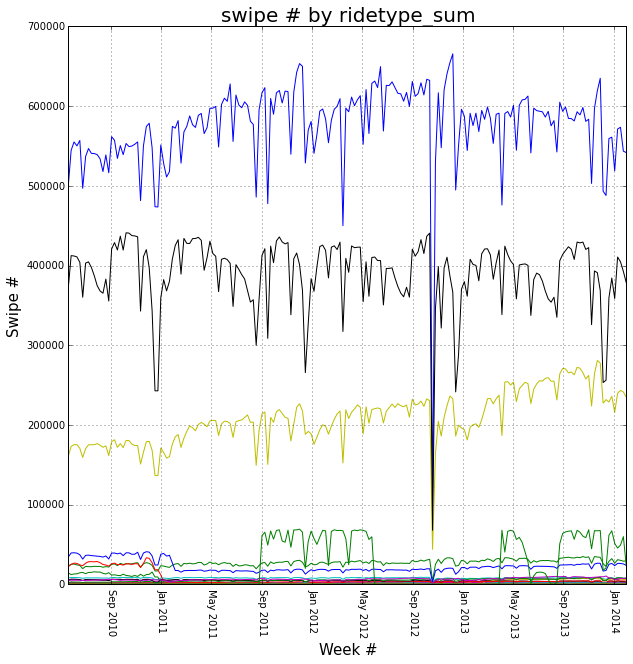

In [25]:
fig1 = plt.figure(figsize=(10,10))
fig1.add_subplot(111)
plt.plot(ridetype1.index, ridetype1)
plt.title('swipe # by ridetype_sum',fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week #', fontsize=15)
plt.ylabel('Swipe #', fontsize=15)
plt.grid()
plt.show

In [16]:
station_avg = np.nanmean(data, axis=1)/600
ridetype_avg = np.nanmean(data, axis=0)/23

C:\Users\wentao\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [17]:
ridetype = pd.DataFrame(ridetype_avg.T)

In [18]:
ridetype.columns = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
                    'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t','umlim',
                    'xbus','stud']

In [19]:
ridetype.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

In [20]:
station = pd.DataFrame(station_avg.T)

In [21]:
station.index = pd.date_range('5/21/2010',periods=194,freq='W-FRI')

<function matplotlib.pyplot.show>

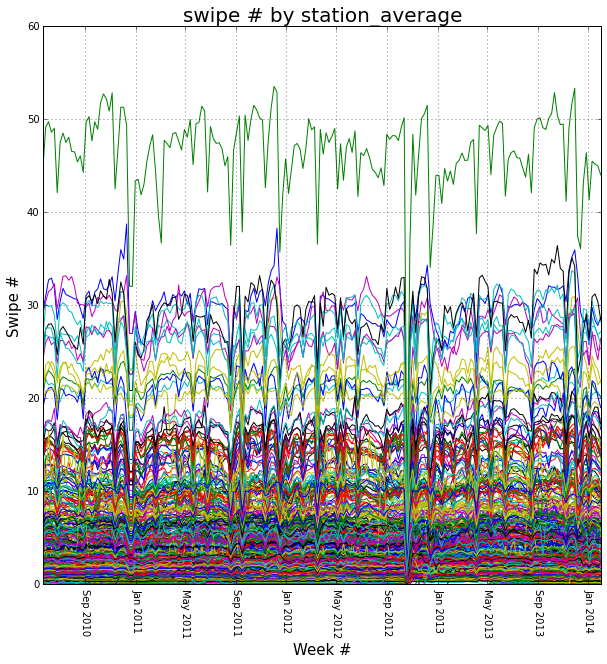

In [26]:
fig1 = plt.figure(figsize=(10,10))
fig1.add_subplot(111)
plt.plot(station.index, station)
plt.title('swipe # by station_average',fontsize=20)
plt.xticks(rotation=270)
plt.xlabel('Week #', fontsize=15)
plt.ylabel('Swipe #', fontsize=15)
plt.grid()
plt.show

## Based on observation, we can detect a huge drop aound 2012 winter time. I gonna detect the event as an outlier using 3 Std from mean as the critical value, I will apply it to swipe # by ridetype_average.

In [30]:
ridetype_num = pd.DataFrame(ridetype_avg.T).convert_objects(convert_numeric=True)

In [31]:
ridetype_num.loc['mean'] = ridetype_num.mean()
ridetype_num.loc['sigma'] = ridetype_num.std()
#ridetype_num.loc['critical min'] = ridetype_num.mean() - 3.0*ridetype_num.std()
#ridetype_num.loc['critical max'] = ridetype_num.mean() + 3.0*ridetype_num.std()

ridetype_num.loc['critical_min'] = ridetype_num.mean() - 3.1*ridetype_num.std()
ridetype_num.loc['critical_max'] = ridetype_num.mean() + 3.1*ridetype_num.std()

In [34]:
# detect if any value in the dataframe is an outlier
realmin = np.where(ridetype_num < ridetype_num.loc['critical_min'])[0]
realmax = np.where(ridetype_num > ridetype_num.loc['critical_max'])[0]

In [35]:
realvalues = np.array(realmin)
np.unique(realvalues)

array([126, 173, 189, 195], dtype=int64)

##according to the detection, we know that week 126, 173, 189, 195 have outliers, also from the previous plot, we know week 126 shows a sharp drop, much sharper than the other weeks. The probable assumption is that the sharp drop is due to hurricane sandy, which caused infrustructures damaged and significantly dropped usage of Metro.

## Task 2

##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [36]:
from scipy import stats
import statsmodels.api as sm

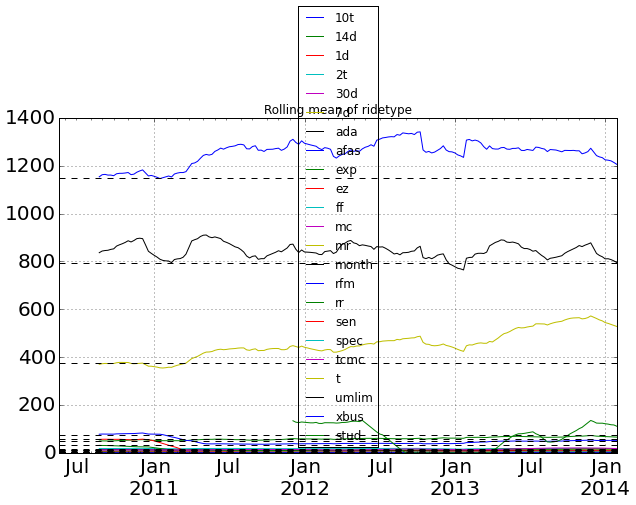

In [37]:
# I picked up 15, not a bad fit.
pd.rolling_mean(ridetype, 15).plot(figsize=(10,6), 
                                   title='Rolling mean of ridetype', fontsize=20)
plt.legend(loc=8)
for x in ridetype.ix['2010-08-06']:
    plt.axhline(x, color='k',linestyle='--')

## We can observe that 10t shows a roughly growing trend, ada is almost stable, 7d/mr/t shows an even more obvious growing trend, and umlim type dropped a little. The others are more difficult to detect by eyes. I gonna display the whole result.

In [38]:
s1 = pd.rolling_mean(ridetype, 12).dropna().head(10)
s2 = pd.rolling_mean(ridetype, 12).dropna().tail(10)

In [40]:
# I calculated the rolling mean for the first and last 10 weeks,
# the one by the other, and took the average
s1.index = np.arange(10)
s2.index = np.arange(10)
ratio = s1/s2
ratio.mean()

10t      1.059771
14d      0.869120
1d       1.042852
2t       1.005811
30d      0.956064
7d       0.813949
ada      1.056366
afas     0.305032
exp      0.924472
ez       1.510246
ff       0.000018
mc       0.648088
mr       0.000015
month    1.336611
rfm      0.730442
rr       0.675629
sen      0.665266
spec     0.975112
tcmc     0.708968
t        1.039908
umlim    1.135261
xbus     0.783629
stud     1.082737
dtype: float64

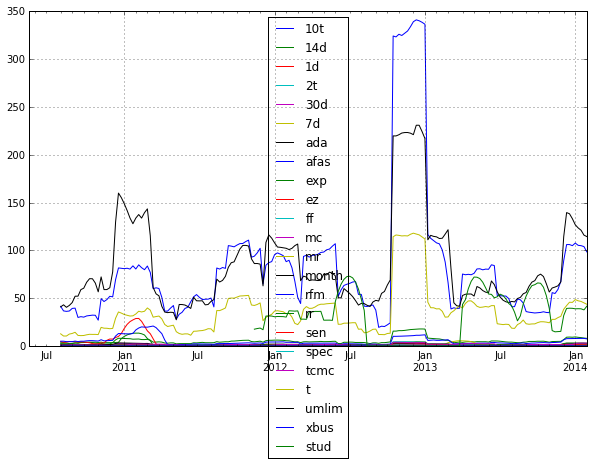

In [41]:
# Now I gonna show the rolling Std
pd.rolling_std(ridetype, 12).plot(figsize=(10,6))
plt.legend(loc=9)

##Task 3:
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [43]:
f = np.abs(np.fft.rfft(station_sum))
f.shape

(600L, 98L)

In [44]:
N =194
ffreq = np.fft.rfftfreq(N, 1.0)
ffreq.shape

(98L,)

In [45]:
station1 = station1.T.astype(float)

C:\Users\wentao\Anaconda\lib\site-packages\matplotlib\axes\_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


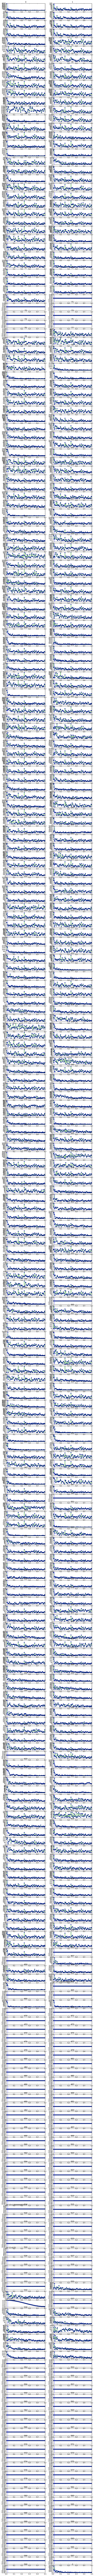

In [46]:
fig = plt.figure(figsize=(10,300))
for i in range(600):
    ax = fig.add_subplot(300,2,i)
    f = np.abs(np.fft.rfft(station1.loc[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
    ax.set_title('%i' %(i-1))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    plt.axvline(1.0/52)

In [48]:
"""fig = plt.figure(figsize=(10,300))
f = np.abs(np.fft.rfft(station1.loc[i]))
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
plt.axvline(1.0/52)"""

"fig = plt.figure(figsize=(10,300))\nf = np.abs(np.fft.rfft(station1.loc[i]))\nax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)\nax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')\nplt.axvline(1.0/52)"